In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
def photodiode(V, a, b):
    return a*V+b

time_without_gradient = [1.800, 4.300]
time_with_gradient = [2.000, 6.500]

timeconstant_without_gradient = {1 : {"tau1" : 1, "tau2" : 1.2},
                                2 : {"tau1" : 1, "tau2" : 1.2},
                                3 : {"tau1" : 100000, "tau2" : 1.2}}

timeconstant_with_gradient = {1 : {"tau1" : 1, "tau2" : 0.9},
                                2 : {"tau1" : 1, "tau2" : 0.9},
                                3 : {"tau1" : 100000, "tau2" : 0.9}}

voltage_without_gradient = {1 : {"init" : 6, "final1" : 2.1, "final2" : 0.34},
                            2 : {"init" : 5.4, "final1" : 2.1, "final2" : 0.35},
                            3 : {"init" : 5.4, "final1" : 5.4, "final2" : 0.095}}
                
voltage_with_gradient = {1 : {"init" : 6, "final1" : 1.1, "final2" : 0.09},
                        2 : {"init" : 5.5, "final1" : 1.1, "final2" : 0.11},
                        3 : {"init" : 5.4, "final1" : 5.4, "final2" : 0.05}}

ODT1_data = np.array([
    [0.472, 0.34],
    [1.471, 1],
    [3.14, 2.1],
    [4.53, 3]])

ODT2_data = np.array([
    [0.45, 0.35],
    [1.297, 1],
    [2.74, 2.1],
    [3.92, 3]])

ODT3_data = np.array([
    [0.046, 0.1],
    [0.091, 0.2],
    [0.232, 0.5],
    [0.377, 0.8]])

popt1, pcov1 = curve_fit(photodiode, ODT1_data[:,1], ODT1_data[:,0])
popt2, pcov2 = curve_fit(photodiode, ODT2_data[:,1], ODT2_data[:,0])
popt3, pcov3 = curve_fit(photodiode, ODT3_data[:,1], ODT3_data[:,0])

In [4]:
popt1, pcov1

(array([ 1.52471615, -0.05154301]),
 array([[ 2.32325904e-05, -3.74044664e-05],
        [-3.74044664e-05,  8.43668122e-05]]))

In [5]:
popt2, pcov2

(array([ 1.3098684, -0.0104128]),
 array([[ 1.28464307e-06, -2.07148626e-06],
        [-2.07148626e-06,  4.66726123e-06]]))

In [6]:
popt3, pcov3

(array([ 0.47333333, -0.00283333]),
 array([[ 1.27777728e-05, -5.11110897e-06],
        [-5.11110897e-06,  3.00277699e-06]]))

In [7]:
str1 = "def ODT1_power(V): return {}*V + {} \n".format(str(popt1[0]), str(popt1[1]))
str2 = "def ODT2_power(V): return {}*V + {} \n".format(str(popt2[0]), str(popt2[1]))
str3 = "def ODT3_power(V): return {}*V + {} \n".format(str(popt3[0]), str(popt3[1]))
L = [str1, str2, str3]
fichier = open('ODT_power.py', 'w')
for  string in L:
    fichier.writelines(string)
fichier.close()

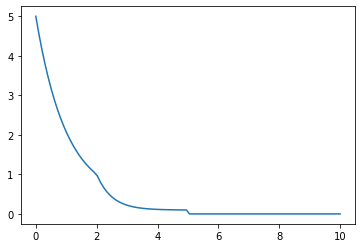

In [8]:
def exponential(V_init, V_final, tau, t_f, t):
    return V_init+(V_final - V_init)*(np.exp(-t/tau)-1)/(np.exp(-t_f/tau)-1)

def two_exponentials(V_init, V_final1, V_final2, tau1, tau2, t_f1, t_f2, t):
    result1 = (t <= t_f1)*exponential(V_init, V_final1, tau1, t_f1, t)
    result2 = (t > t_f1)*(t <= t_f2)*exponential(V_final1, V_final2, tau2, t_f2 - t_f1, t - t_f1)
    return result1 + result2

V_init, V_final1, V_final2, tau1, tau2, t_f1, t_f2 = [5, 1, 0.1, 1, 0.5, 2, 5]
t = np.linspace(0, 10, 100)
plt.figure()
plt.plot(t, two_exponentials(V_init, V_final1, V_final2, tau1, tau2, t_f1, t_f2, t))
plt.show()

In [9]:
str0 = """
import numpy as np \n
time_without_gradient = {} \n
time_with_gradient = {} \n
timeconstant_without_gradient = {} \n
voltage_without_gradient = {} \n
timeconstant_with_gradient = {} \n
voltage_with_gradient = {} \n""".format(str(time_without_gradient), str(time_with_gradient),
                                    str(timeconstant_without_gradient), str(voltage_without_gradient),
                                     str(timeconstant_with_gradient), str(voltage_with_gradient))

str1 = """
def exponential(V_init, V_final, tau, t_f, t):
    return V_init+(V_final - V_init)*(np.exp(-t/tau)-1)/(np.exp(-t_f/tau)-1)

def two_exponentials(V_init, V_final1, V_final2, tau1, tau2, t_f1, t_f2, t):
    result1 = (t <= t_f1)*exponential(V_init, V_final1, tau1, t_f1, t)
    result2 = (t > t_f1)*(t <= t_f2)*exponential(V_final1, V_final2, tau2, t_f2 - t_f1, t - t_f1)
    return result1 + result2 \n"""

str2 = """
def ODT_voltage_to_power(ODT_number, V):
    if ODT_number == 1:
        return {}*V + {}
    elif ODT_number == 2:
        return {}*V + {}
    elif ODT_number == 3:
        return {}*V + {} \n""".format(str(popt1[0]), str(popt1[1]), str(popt2[0]), str(popt2[1]), str(popt3[0]), str(popt3[1]))

str3 = """
def ODT_voltage(ODT_number, t, with_gradient = False):
    if with_gradient:
        voltage = voltage_with_gradient[ODT_number]
        timeconstant = timeconstant_with_gradient[ODT_number]
        t_f1, t_f2 = time_with_gradient
    else:
        voltage = voltage_without_gradient[ODT_number]
        timeconstant = timeconstant_without_gradient[ODT_number]
        t_f1, t_f2 = time_without_gradient
    return two_exponentials(voltage["init"], voltage["final1"], voltage["final2"], timeconstant["tau1"], timeconstant["tau2"], t_f1, t_f2, t) \n"""

str4 = """
def ODT_power(ODT_number, t, with_gradient = False):
    return ODT_voltage_to_power(ODT_number, ODT_voltage(ODT_number, t, with_gradient)) \n
"""

L = [str0, str1, str2, str3, str4]
fichier = open('ODT_power.py', 'w')
for  string in L:
    fichier.writelines(string)
fichier.close()

In [10]:
timeconstant_with_gradient

{1: {'tau1': 1, 'tau2': 0.9},
 2: {'tau1': 1, 'tau2': 0.9},
 3: {'tau1': 100000, 'tau2': 0.9}}